# Accesibilidad a áreas verdes en la Zona Metropolitana del Valle de México

En este taller vamos a calcular diferentes modelos de accesibilidad a escuelas primarias. La idea es ir trabajando de lo más simple a los más complejo. Empezaremos con un modelo de conectividad basado sólo en distancias entre centroides e iremos complicando las cosas a partir de ahí, primero usando conectividad de red...

### Hecho por: 
**Daniel Cruz**, **Dalia Lagunes**, **David Martínez** **y Ulises Morales**

Temas selectos de Geoinformatica, Maestría en Ciencias de Información Geoespacial, CentroGeo
****

## Planteamiento del problema

La disponibilidad de escuelas primarias es un buen ejercicio para utilizar la librería access de PySAL, ya que se trata de elementos que dependen de dos ubicaciones una que representa una oferta y una que representa una demanda. 
Los datos necesarios son las escuelas de nivel primaria de la zona metropolitana así como la población de la misma zona dentro del rango de edad de 6 a 13 años
También se comparan dos tipos de modelos distintos gravitatorio y RAAM


## Preparación de datos

Para este trabajo se utilizaron los datos del marco cartográfico del Censo de 2020 a nivel AGEB y una cartografía de las primarias en la zona Metropolitana del Valle de México

Los datos de las primarias se obtuvieron de la página de la SEP https://www.siged.sep.gob.mx/SIGED/escuelas.html en formato excel. Se seleccionaron solamente las primarias de la Ciudad de México y el Estado de México.

In [1]:
#!pip install geopandas access contextily


Se importan las librerías necesarias incluida Access que es parte de Python spatial analysis library que es una librería enfocada en datos geoespaciales, Access tiene como objetivo calcular medidas de accesibilidad espacial utilizando los tiempos de viaje y ubicaciones de oferta y demanda.

In [2]:
import pandas as pd
import geopandas as gpd
from access import Access, weights
import matplotlib.pyplot as plt
import contextily as ctx
import math
import numpy as np

/home/david/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


Se importan los datos de las escuelas de la CDMX y del Estado de México

In [3]:
escuelas_cdmx = pd.read_excel(r"./datos/concentrado_escuelas_cdmx.xlsx")
escuelas_cdmx.head()
print(escuelas_cdmx.shape)

(3300, 40)


In [4]:
escuelas_edomex = pd.read_excel('./datos/concentrado_escuelas_edomex.xlsx')
escuelas_edomex.head()
print(escuelas_edomex.shape)

(9152, 40)


In [5]:
# Concateno los df de las escuelas de la cdmx y el edomex
frames = [escuelas_cdmx, escuelas_edomex]
escuelas_zmvm = pd.concat(frames)
print(escuelas_zmvm.shape)

(12452, 40)


Obtenemos la ubicación a partir de la longitud y latitud

In [6]:
escuelas_zmvm.columns


Index(['Clave del centro de trabajo', 'Clave del turno', 'Nombre del turno',
       'Nombre del centro de trabajo', 'Tipo educativo', 'Nivel educativo',
       'Servicio educativo', 'Nombre del control (Público o Privado)',
       'Tipo de sostenimiento', 'Clave de la entidad federativa',
       'Nombre de la entidad', 'Clave del municipio o delegación',
       'Nombre del municipio o delegación', 'Clave de la localidad',
       'Nombre de localidad', 'Domicilio', 'Número exterior', 'Entre la calle',
       'Y la calle', 'Calle posterior', 'Colonia', 'Nombre de la colonia',
       'Código postal', 'Clave lada', 'Teléfono', 'Extensión del teléfono',
       'Página web', 'Alumnos total (hombres)', 'Alumnos total (mujeres)',
       'Alumnos total', 'Docentes total (hombres)', 'Docentes total (mujeres)',
       'Docentes total', 'Aulas en uso', 'Aulas existentes',
       'Tipo de localidad U - Urbano, R - Rural',
       'Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich

La gráfica se muestra de manera errónea esto debido a que algunos de los datos que aparecen tienen errores en las coordenadas por lo cual aparecen en otras ubicaciones.

Se corrigió utilizando longitudes menores a -75 grados, dejando solo los valores pertenecientes a la Zona Metropolitana

In [7]:
escuelas_zmvm_gdf = gpd.GeoDataFrame(
    escuelas_zmvm, geometry=gpd.points_from_xy(
        escuelas_zmvm['Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados'], 
                      escuelas_zmvm['Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados']))

In [8]:
escuelas_zmvm_gdf.head()

,Clave del centro de trabajo,Clave del turno,Nombre del turno,Nombre del centro de trabajo,Tipo educativo,Nivel educativo,Servicio educativo,Nombre del control (Público o Privado),Tipo de sostenimiento,Clave de la entidad federativa,...,Docentes total (mujeres),Docentes total,Aulas en uso,Aulas existentes,"Tipo de localidad U - Urbano, R - Rural","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados",geometry
0,09DPR1317S,2,VESPERTINO,PROFR. DANIEL DELGADILLO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,6.0,6.0,6.0,17.0,NaN,99:6:48.60 W,19:28:58.44 N,-99.1135,19.4829,POINT (-99.11350 19.48290)
1,09PPR1197A,1,MATUTINO,"""COLEGIO """"TRILINGÜE PEDRO MARIA ANAYA""""""",BÁSICA,PRIMARIA,GENERAL,PRIVADO,PRIVADO,9.0,...,3.0,3.0,6.0,6.0,NaN,99:11:3.84 W,19:29:2.76 N,-99.1844,19.4841,POINT (-99.18440 19.48410)
2,09DPR0943D,1,MATUTINO,ING. JOAQUIN GALLO MONTERRUBIO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,11.0,12.0,12.0,12.0,NaN,99:5:51.36 W,19:23:45.24 N,-99.0976,19.3959,POINT (-99.09760 19.39590)
3,09DPR1177I,1,MATUTINO,JUANA DE ASBAJE,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,9.0,12.0,12.0,12.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.0926,19.3590,POINT (-99.09260 19.35900)
4,09DPR1217T,2,VESPERTINO,ING. ROBERTO GAYOL,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,7.0,10.0,10.0,18.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.0926,19.3590,POINT (-99.09260 19.35900)


<AxesSubplot:>

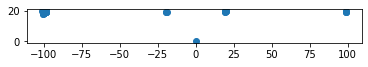

In [9]:
escuelas_zmvm_gdf.plot()

Se limitó el nivel educativo a primaria 

<AxesSubplot:>

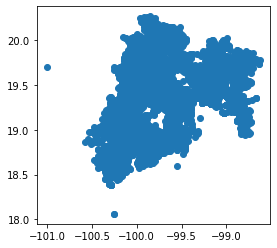

In [10]:
longitud_correcta = escuelas_zmvm_gdf['Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados'] < -75
escuelas_zmvm_gdf = escuelas_zmvm_gdf[longitud_correcta]
escuelas_zmvm_gdf.plot()

In [11]:
escuelas_zmvm_gdf = escuelas_zmvm_gdf[['Nivel educativo', 'Docentes total', 'Alumnos total', 'geometry']]

In [12]:
options = ['PRIMARIA']
escuelas_zmvm_gdf = escuelas_zmvm_gdf[escuelas_zmvm_gdf['Nivel educativo'].isin(options)]

Se importan los datos de las agebs de la CDMX y del Estado de México así como el límite metropolitano


In [13]:
agebs_cdmx = gpd.read_file("./datos/agebs_cdmx_2020.zip")
agebs_edomex = gpd.read_file("./datos/agebs_edomex_2020.zip")
limite_metropolitano = gpd.read_file("./datos/limite_metropolitano.zip")

se hizo un merge de las agebs para tenerlas en un solo dataframe

In [14]:
agebs_todas = pd.concat([agebs_cdmx, agebs_edomex])
agebs_todas.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry
0,0901000011716,09,010,0001,1716,"POLYGON ((2787237.541 816989.461, 2787288.728 ..."
1,0901000012150,09,010,0001,2150,"POLYGON ((2794154.458 823013.444, 2794155.774 ..."
2,0901000011133,09,010,0001,1133,"POLYGON ((2795690.723 820050.788, 2795684.238 ..."
3,0901000011307,09,010,0001,1307,"POLYGON ((2792584.475 815678.668, 2792624.325 ..."
4,0901000010281,09,010,0001,0281,"POLYGON ((2788845.392 823526.074, 2788840.549 ..."


Graficamos las agebs para observar su ubicación 

<AxesSubplot:>

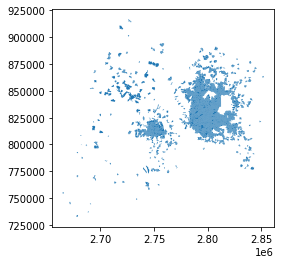

In [15]:
agebs_todas.plot()

### Proyectar
Para poder cortar las geometrías y trabajarlas todas juntas necesitamos que estén en la misma proyección

In [16]:
escuelas_zmvm_gdf = escuelas_zmvm_gdf.set_crs('epsg:4326')

Las primeras dos están en la proyección nueva de INEGI, las áreas verdes en la anterior y el límite metropolitano está en 32614. Tenemos que poner todas en la misma proyección, podría ser cualquiera de las planas (vamos a medir longitudes). Usemos la nueva del INEGI

In [17]:
escuelas_zmvm_gdf = escuelas_zmvm_gdf.to_crs(agebs_todas.crs)
limite_metropolitano = limite_metropolitano.to_crs(agebs_todas.crs)

In [18]:
print(escuelas_zmvm_gdf.crs)
print("")
print(agebs_todas.crs)

PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_2008",DATUM["ITRF_2008",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["False_Easting",2500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-102.0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Latitude_Of_Origin",12.0],UNIT["Meter",1.0]]

PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_2008",DATUM["ITRF_2008",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["False_Easting",2500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-102.0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Latitude_Of_Origin",12.0],UNIT["Meter",1.0]]


### Cortar con el límite metropolitano

### Áreas y centroides

Como vamos a trabajar la accesibilidad en primera instancia sólo entre los centroides de las agebs y las de las áreas verdes, entonces vamos a necesitar dataframes con el área de los parques (que vamos a usar como la oferta en el modelo de accesibilidad) y con los centroides de las agebs y su población total (que va a ser la demanda).

**Nota:** vamos a hacer una copia de las capas para usdar los centroides, en caso de que queramos después usar las geometrías originales

In [19]:
from geopandas.tools import sjoin

escuelas_zm_gdf = sjoin(escuelas_zmvm_gdf, limite_metropolitano)
agebs_zmvm = sjoin(agebs_todas, limite_metropolitano)

### Áreas y centroides

Al trabajar la accesibilidad en primera instancia sólo entre los centroides de las agebs y las escuelas, entonces vamos a necesitar dataframes con la matrícula de las escuelas (que vamos a usar como la oferta en el modelo de accesibilidad) y con los centroides de las agebs y su población total (que va a ser la demanda).

**Nota:** vamos a hacer una copia de las capas para usar los centroides, en caso de que queramos después usar las geometrías originales

<AxesSubplot:>

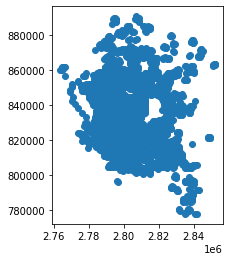

In [20]:
# Nos quedamos sólo con los campos que queremos
agebs_zmvm_centroides = agebs_zmvm.copy()
agebs_zmvm_centroides['geometry'] = agebs_zmvm_centroides.centroid
# Nos quedamos sólo con los campos que queremos
agebs_zmvm_centroides = agebs_zmvm_centroides.loc[:, ['CVEGEO', 'geometry']]
agebs_zmvm_centroides.plot()

In [21]:
# Nos conviene tener una columna que identifique a cada parque
escuelas_zmvm_gdf = escuelas_zmvm_gdf[~escuelas_zmvm_gdf.geometry.is_empty]
escuelas_zmvm_gdf = escuelas_zmvm_gdf.reset_index().rename({'index':'id_escuela'}, axis=1)
escuelas_zmvm_gdf.head()

,id_escuela,Nivel educativo,Docentes total,Alumnos total,geometry
0,0,PRIMARIA,6.0,106.0,POINT (2802113.976 834649.424)
1,1,PRIMARIA,3.0,98.0,POINT (2794691.631 834634.323)
2,2,PRIMARIA,12.0,337.0,POINT (2803972.228 825082.509)
3,3,PRIMARIA,12.0,331.0,POINT (2804578.376 821020.898)
4,4,PRIMARIA,10.0,187.0,POINT (2804578.376 821020.898)


### Datos de población
Para modelar la demanda necesitamos ahora unir a las agebs los datos de población, esos vienen en csvs por estado. Lo primero es leerlos y juntarlos en un solo dataframe

In [22]:
pob_cdmx = pd.read_csv("./datos/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
pob_edomex = pd.read_csv("./datos/conjunto_de_datos_ageb_urbana_15_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
pob_zmvm = pd.concat([pob_cdmx, pob_edomex])
# seleccionamos las filas que contienen los totales para cada AGEB
pob_zmvm = pob_zmvm.loc[pob_zmvm['NOM_LOC'] == 'Total AGEB urbana', :]
# Construimos una columna con la clave de ageb
pob_zmvm['CVEGEO'] = pob_zmvm['ENTIDAD'] + pob_zmvm['MUN'] + pob_zmvm['LOC'] + pob_zmvm['AGEB']
pob_zmvm.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,CVEGEO
3,09,Ciudad de México,002,Azcapotzalco,0001,Total AGEB urbana,0010,0,3183,1695,...,772,692,313,221,145,8,14,148,5,0900200010010
30,09,Ciudad de México,002,Azcapotzalco,0001,Total AGEB urbana,0025,0,5593,2915,...,1510,1203,478,349,238,28,68,393,14,0900200010025
82,09,Ciudad de México,002,Azcapotzalco,0001,Total AGEB urbana,003A,0,4235,2232,...,1049,878,361,339,247,5,12,250,*,090020001003A
116,09,Ciudad de México,002,Azcapotzalco,0001,Total AGEB urbana,0044,0,4768,2551,...,1237,1076,481,452,294,10,17,254,*,0900200010044
163,09,Ciudad de México,002,Azcapotzalco,0001,Total AGEB urbana,0097,0,2176,1115,...,562,507,276,260,153,4,3,70,0,0900200010097


In [23]:
pob_zmvm.loc[pob_zmvm['P_6A11'] == '*', 'P_6A11'] = 0

In [24]:
#poblacion_interes = ['P_6A11', 'P_12A14', 'P_15A17']
poblacion_interes = ['P_6A11']
pob_zmvm['SUMA'] = pob_zmvm[poblacion_interes].sum(axis=1)

In [25]:
# Nos quedamos sólo con las columnas que vamos a usar (sólo queremos los datos de población)
pob_zmvm = pob_zmvm.loc[:, ['CVEGEO', 'SUMA']]
pob_zmvm.head()

,CVEGEO,SUMA
3,0900200010010,171.0
30,0900200010025,342.0
82,090020001003A,269.0
116,0900200010044,275.0
163,0900200010097,105.0


In [26]:
# Hacer aquí un mapa de cloropletas para mostrar en colores la población en cada ageb

Ahora los podemos unir con los centroides de las agebs y eliminamos datos_zmvm porque ya no lo vmos a usar y ocupa mucha memoria

In [27]:
agebs_zmvm_centroides = agebs_zmvm_centroides.merge(pob_zmvm, on="CVEGEO", how="inner")
# eliminamos datos_zmvm porque ya no lo vmos a usar y ocupa mucha memoria
pob_zmvm = None
agebs_zmvm_centroides.head()

,CVEGEO,geometry,SUMA
0,0901000011716,POINT (2787091.708 816590.463),667.0
1,0901000012150,POINT (2793986.972 823047.548),285.0
2,0901000011133,POINT (2794967.016 819439.549),108.0
3,0901000011307,POINT (2792230.506 815397.361),160.0
4,0901000010281,POINT (2788669.707 823554.634),18.0


Aquí vamos a guardar todos los datos como pickle para usarlos en otros notebooks

In [28]:
# Aquí vamos a guardar todos los datos como pickle para usarlos en otros notebooks
agebs_zmvm_centroides.to_file("./datos/agebs_zmvm_centroides.gpkg", layer='agebs_zmvm_centroides', driver='GPKG')
escuelas_zmvm_gdf.to_file("./datos/escuelas_zmvm_centroides.gpkg", layer='escuelas_zmvm_centroides', driver='GPKG')

In [29]:
from joblib import Parallel, delayed
import time
def parallel_get_od_matrix(agebs_zmvm_centroides, escuelas_zmvm_gdf, njobs):
    def parallel_row(index_i, index_j):

        lista = []

        origen = agebs_zmvm_centroides.CVEGEO[index_i]
        destino = escuelas_zmvm_gdf.id_escuela[index_j]
        costo = float(math.sqrt(pow(agebs_zmvm_centroides.geometry[index_i].x-escuelas_zmvm_gdf.geometry[index_j].x,2)
                                      +pow(agebs_zmvm_centroides.geometry[index_i].y-escuelas_zmvm_gdf.geometry[index_j].y,2)))

        lista.append([origen, destino, costo])

        return lista

        df = pd.DataFrame(lista, columns=["origen", "destino", "costo"])
    
    df = Parallel(n_jobs=njobs)(delayed(parallel_row)(index_i, index_j) 
                                for index_i, _ in agebs_zmvm_centroides.iterrows() 
                               for index_j, _ in escuelas_zmvm_gdf.iterrows())
    
    return df

In [ ]:
start = time.time()
# n_jobs is the number of parallel jobs
df = parallel_get_od_matrix(agebs_zmvm_centroides, escuelas_zmvm_gdf, 6)
end = time.time()
print('{:.4f} s'.format(end-start))

In [ ]:
df

In [ ]:
df = pd.DataFrame(np.concatenate(df), columns=["origen", "destino", "costo"])
df

In [ ]:
df.to_csv("./datos/escuelas_od_euclidean.csv", index=False)

## Modelo basado en distancia euclidiana

La primera aproximación que vamos a usar es crear un modelo de accesibilidad basado en la distancia euclidiana entre los centroides de las agebs y los de los parques. Para esto, el primer paso es construir una matriz de costos

### Matriz de costos

Para construir la matriz de costos necesitamos obtener el producto cruz de nuestros datos de origen y destino. A partir de eso, podemos calcular la distancia euclidiana y guardar el resultado en la matriz. En general, podríamos ralizar todo el proceso con el siguiente código:

````Python
# Creamos el producto cruz
#cost_df = agebs_zmvm_centroides[['CVEGEO']].merge(areas_verdes_centroides[['id_parque']], how='cross')
cost_df = agebs_zmvm_centroides[['CVEGEO']].merge(escuelas[['id_escuela']], how='cross')
# Agregamos una columna de costo con puros ceros
cost_df['cost'] = 0
# renombramos las columnas para que tengan más sentido
cost_df.columns = ['origen', 'destino', 'cost']
# Instanciamos un objeto de la clase Access
A = Access(demand_df            = agebs_zmvm_centroides,
           demand_index         = 'CVEGEO',
           demand_value         = 'sum',
           supply_df            = areas_verdes_centroides,
           supply_index         = 'id_escuela',
           supply_value         = 'area',
           cost_df              = costo_euclidiano,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean',
           neighbor_cost_df     = costo_euclidiano,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'euclidean')
# Calculamos las distancias
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)
````
Como esta operación requiere mucha memoria y tiempo, en lugar de ejecutarla vamos a usar un dataframe con los datos precalculados

In [ ]:
costo_euclidiano = pd.read_csv("./datos/escuelas_od_euclidean.csv")
costo_euclidiano

### Instancia de accesibilidad

Ya tenemos los datos preparados, ahora podemos crear una instancia de la clase `access` con nuestros centros de demanda y de oferta. 

In [ ]:
from access import Access, weights
A = Access(demand_df            = agebs_zmvm_centroides,
           demand_index         = 'CVEGEO',
           demand_value         = 'SUMA',
           supply_df            = escuelas_zmvm_gdf,
           supply_index         = 'id_escuela',
           supply_value         = 'Alumnos total',
           cost_df              = costo_euclidiano,
           cost_origin          = 'origen',
           cost_dest            = 'destino',
           cost_name            = 'costo',
           neighbor_cost_df     = costo_euclidiano,
           neighbor_cost_origin = 'origen',
           neighbor_cost_dest   = 'destino',
           neighbor_cost_name   = 'costo')

### Modelos de accesibilidad
Ahora ya tenemos todos los datos que necesitamos para calcular diferentes modelos de accesibilidad. El ajuste de cada modelos para la cantidad de datos que estamos utilizando es un poco lento, entonces vamos a calcular sólo unos pocos y ver sus diferencias

In [ ]:
# stepwise weight dictionaries
fn1 = weights.step_fn({750 : 1, 1500 : 0.68, 3000 : 0.22})
# gaussian media de 1000 metros 
gaussian = weights.gaussian(750)
# gravity catchement pesado por gravedad
gravity = weights.gravity(scale = 750, alpha = -1)

In [ ]:
A.weighted_catchment(name = "gravity", weight_fn = gravity)
A.raam(name = "raam", tau = 5)

In [ ]:
# Guardamos los modelos por si los queremos reutilizar
A.norm_access_df.to_csv("./datos/accesibilidad_primarias_distancia_euclidiana.csv")

Ahora podemos comparar los dos modelos de accesibilidad. Primero unimos los datos de acceesibilidad a las geometrías de los centroides 

In [ ]:
mapa_accesibilidad = agebs_zmvm_centroides.set_index('CVEGEO')[['geometry']].join(A.norm_access_df, how = "inner")
mapa_accesibilidad

Y ahora podemos hacer un par de mapas para compararlos

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32,12))
ax1 = mapa_accesibilidad.to_crs(epsg=3857).plot('raam_Alumnos total', legend = True,
                                                cmap =  "viridis_r", 
                                                markersize = 5, alpha = 0.9, ax = ax1,
                                                vmin = mapa_accesibilidad['raam_Alumnos total'].quantile(0.05), 
                                                vmax = mapa_accesibilidad['raam_Alumnos total'].quantile(0.95),
                                                )
ax1.set_axis_off()
ax1.set(title='Modelo RAAM')
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)

ax2 = mapa_accesibilidad.to_crs(epsg=3857).plot('gravity_Alumnos total', legend = True,
                                                cmap =  "viridis", 
                                                markersize = 5, alpha = 0.9, ax = ax2,
                                                vmin = mapa_accesibilidad['gravity_Alumnos total'].quantile(0.05), 
                                                vmax = mapa_accesibilidad['gravity_Alumnos total'].quantile(0.95),
                                                )
ax2.set_axis_off()
ax2.set(title='Modelo Gravitatorio')
# plt.subplots_adjust(wspace=-.5, hspace=0)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()